In [329]:
# import all relevant libraries
import pandas as pd
import numpy as np
import uuid
import re
import json
from pandas.plotting import register_matplotlib_converters
from pandas import json_normalize
import matplotlib.pyplot as plt

In [330]:
charging = pd.read_csv("../charging_sessions.csv", encoding = "ISO-8859-1")

In [331]:
charging.head()

,Unnamed: 0,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil..."
1,1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil..."
2,2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
3,3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
4,4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil..."


In [332]:
charging.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        66450 non-null  int64  
 1   id                66450 non-null  object 
 2   connectionTime    66450 non-null  object 
 3   disconnectTime    66450 non-null  object 
 4   doneChargingTime  62362 non-null  object 
 5   kWhDelivered      66450 non-null  float64
 6   sessionID         66450 non-null  object 
 7   siteID            66450 non-null  int64  
 8   spaceID           66450 non-null  object 
 9   stationID         66450 non-null  object 
 10  timezone          66450 non-null  object 
 11  userID            49187 non-null  float64
 12  userInputs        49187 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 6.6+ MB


In [333]:
#remove duplicate users. (Keep only first user, throw out next)
#state reason here
charging = charging[~charging['id'].duplicated(keep=False)]

In [334]:
charging = charging.drop(columns=['Unnamed: 0']).reset_index(drop=True)

charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])
charging['disconnectTime'] = pd.to_datetime(charging['disconnectTime'])
charging['doneChargingTime'] = pd.to_datetime(charging['doneChargingTime'])

#id sind floats in CSV aber sind alle ints
#null werte zu 0.0 umwandeln
charging['userID'] = charging['userID'].fillna(0.0)
charging['userID'] = charging['userID'].astype(int)

charging.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63624 entries, 0 to 63623
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                63624 non-null  object             
 1   connectionTime    63624 non-null  datetime64[ns, UTC]
 2   disconnectTime    63624 non-null  datetime64[ns, UTC]
 3   doneChargingTime  59538 non-null  datetime64[ns, UTC]
 4   kWhDelivered      63624 non-null  float64            
 5   sessionID         63624 non-null  object             
 6   siteID            63624 non-null  int64              
 7   spaceID           63624 non-null  object             
 8   stationID         63624 non-null  object             
 9   timezone          63624 non-null  object             
 10  userID            63624 non-null  int32              
 11  userInputs        46457 non-null  object             
dtypes: datetime64[ns, UTC](3), float64(1), int32(1), int64(1), o

In [335]:
def parse_json(x):
    if isinstance(x, str):
        x = x.replace("'", '"').strip()
        x = re.sub(r'\bTrue\b', 'true', x)
        x = re.sub(r'\bFalse\b', 'false', x)    
        try:
            return json.loads(x)
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e} | Input: {x}")  # Print error and input
            return []  # Return an empty list if parsing fails
    return []

charging['userInputs'] = charging['userInputs'].apply(parse_json)
user_inputs_expanded = json_normalize(charging['userInputs'].explode()).add_prefix('userInputs_')
charging = charging.drop(columns=['userInputs']).reset_index(drop=True).join(user_inputs_expanded.reset_index(drop=True))

charging['userInputs_userID'] = charging['userID'].astype(int)

charging.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63624 entries, 0 to 63623
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   id                             63624 non-null  object             
 1   connectionTime                 63624 non-null  datetime64[ns, UTC]
 2   disconnectTime                 63624 non-null  datetime64[ns, UTC]
 3   doneChargingTime               59538 non-null  datetime64[ns, UTC]
 4   kWhDelivered                   63624 non-null  float64            
 5   sessionID                      63624 non-null  object             
 6   siteID                         63624 non-null  int64              
 7   spaceID                        63624 non-null  object             
 8   stationID                      63624 non-null  object             
 9   timezone                       63624 non-null  object             
 10  userID                

In [336]:
#check if userInputs_userID always equal to userID
# 
charging['userID_matches'] = charging['userID'] == charging['userInputs_userID']
charging['userID_matches'].describe()

count     63624
unique        1
top        True
freq      63624
Name: userID_matches, dtype: object

In [337]:
charging = charging.drop(columns=['userID_matches']).reset_index(drop=True)
charging = charging.drop(columns=['userInputs_userID']).reset_index(drop=True)
charging.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63624 entries, 0 to 63623
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   id                             63624 non-null  object             
 1   connectionTime                 63624 non-null  datetime64[ns, UTC]
 2   disconnectTime                 63624 non-null  datetime64[ns, UTC]
 3   doneChargingTime               59538 non-null  datetime64[ns, UTC]
 4   kWhDelivered                   63624 non-null  float64            
 5   sessionID                      63624 non-null  object             
 6   siteID                         63624 non-null  int64              
 7   spaceID                        63624 non-null  object             
 8   stationID                      63624 non-null  object             
 9   timezone                       63624 non-null  object             
 10  userID                

<h2> Beobachtung: Manchmal ist disconnectionTime < doneCharging. Lösung: set doneChargingTime = disconnectTime. Differenz war immer 1-2 minuten. überprüfe bei welchen Stationen das hier auftritt

In [339]:
# Add a flag column to indicate rows where doneChargingTime is after disconnectTime
charging['done_after_disconnect'] = charging['doneChargingTime'] > charging['disconnectTime']

# Group by siteID and stationID, and check if any session has done_after_disconnect = True
defect_stations = charging.groupby(['siteID', 'stationID'])['done_after_disconnect'].any().reset_index()

# Count the number of defect stations per site
defect_stations_per_site = defect_stations.groupby('siteID')['done_after_disconnect'].sum().reset_index(name='defect_station_count')

# Count the total number of stations per site
total_stations_per_site = charging.groupby('siteID')['stationID'].nunique().reset_index(name='total_station_count')

# Merge the defect and total station counts
station_stats = pd.merge(defect_stations_per_site, total_stations_per_site, on='siteID')

# Calculate the percentage of defect stations per site
station_stats['defect_station_percentage'] = (station_stats['defect_station_count'] / station_stats['total_station_count']) * 100

# Display the result
print(station_stats)

charging = charging.drop(columns=['done_after_disconnect'])

   siteID  defect_station_count  total_station_count  \
0       1                    52                   52   
1       2                    53                   55   

   defect_station_percentage  
0                 100.000000  
1                  96.363636  


In [340]:
# Add a flag column to indicate rows where doneChargingTime is after disconnectTime
charging['done_after_disconnect'] = charging['doneChargingTime'] > charging['disconnectTime']

# Count the number of defect sessions per site
defect_sessions_per_site = charging.groupby('siteID')['done_after_disconnect'].sum().reset_index(name='defect_session_count')

# Sort the results to see which site has the most defect sessions
defect_sessions_per_site = defect_sessions_per_site.sort_values(by='defect_session_count', ascending=False)

# Display the result
print(defect_sessions_per_site)

charging = charging.drop(columns=['done_after_disconnect'])

   siteID  defect_session_count
0       1                  2902
1       2                  1180


C:\Users\Willi\AppData\Local\Temp\ipykernel_6400\1220045244.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=occurrence_counts, x='site_station', y='count', palette='viridis')


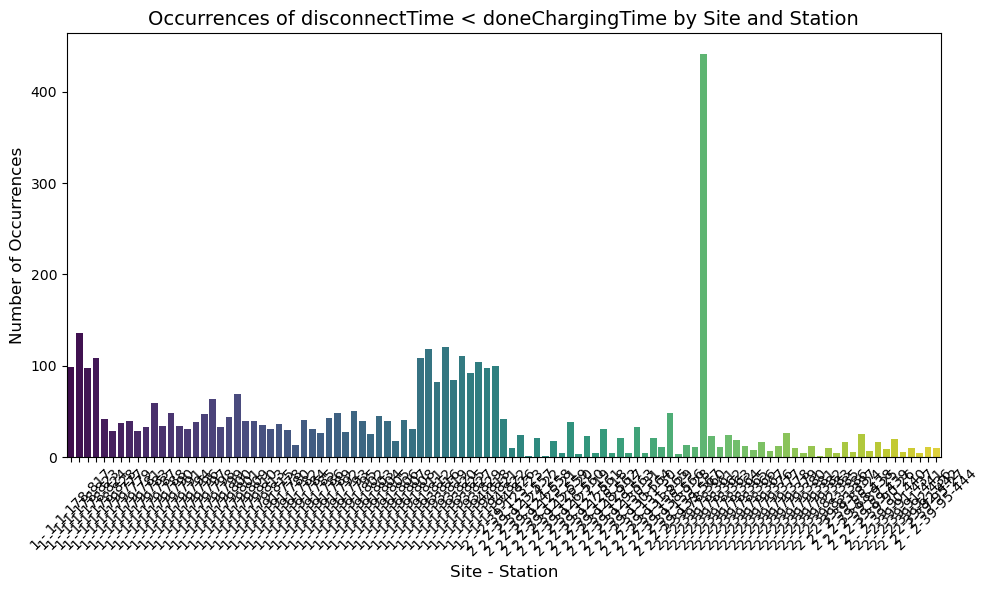

In [341]:
import seaborn as sns

# Create a combined column for siteID and stationID
occurrence_counts['site_station'] = occurrence_counts['siteID'].astype(str) + ' - ' + occurrence_counts['stationID']

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(data=occurrence_counts, x='site_station', y='count', palette='viridis')

# Customize the plot
plt.title('Occurrences of disconnectTime < doneChargingTime by Site and Station', fontsize=14)
plt.xlabel('Site - Station', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [342]:
# Add a flag column to indicate rows where doneChargingTime is after disconnectTime
charging['done_after_disconnect'] = charging['doneChargingTime'] > charging['disconnectTime']

# Count the number of defect sessions per station
defect_sessions_per_station = charging.groupby(['siteID', 'stationID'])['done_after_disconnect'].sum().reset_index(name='defect_session_count')

# Sort the results to see which station has the most defect sessions
defect_sessions_per_station = defect_sessions_per_station.sort_values(by='defect_session_count', ascending=False)

# Display the result
print(defect_sessions_per_station)

    siteID     stationID  defect_session_count
76       2   2-39-78-362                   442
1        1   1-1-178-823                   136
45       1   1-1-193-825                   121
43       1   1-1-193-819                   118
47       1   1-1-193-829                   111
..     ...           ...                   ...
57       2  2-39-125-559                     1
92       2   2-39-82-385                     1
55       2  2-39-124-558                     1
91       2   2-39-82-384                     0
90       2  2-39-81-4550                     0

[107 rows x 3 columns]


Station 2-39-78-362 has an abnormal amount of defect sessions -> might have a slight defect, as it is out of more than 60.000 sessions

In [344]:
# Ensure disconnectTime is always after doneChargingTime
charging['doneChargingTime'] = charging.apply(
    lambda row: row['disconnectTime'] if row['disconnectTime'] < row['doneChargingTime'] else row['doneChargingTime'],
    axis=1
)

In [345]:
charging['connectionDay'] = charging['connectionTime'].dt.date
charging['disconnectionDay'] = charging['disconnectTime'].dt.date

charging['date_matches'] = charging['connectionDay'] == charging['disconnectionDay']
charging['date_matches'].describe()


count     63624
unique        2
top        True
freq      36517
Name: date_matches, dtype: object

*not all loading processes start and end on the same day*

proposed solution: split charging processes on 2 different dates into 2 with uniform distribution of kWhDelivered and first start time + 0:00 and second 0:00 + end time
**this is only necessary when checking charging processes based on day**

In [348]:
charging.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63624 entries, 0 to 63623
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   id                             63624 non-null  object             
 1   connectionTime                 63624 non-null  datetime64[ns, UTC]
 2   disconnectTime                 63624 non-null  datetime64[ns, UTC]
 3   doneChargingTime               59538 non-null  datetime64[ns, UTC]
 4   kWhDelivered                   63624 non-null  float64            
 5   sessionID                      63624 non-null  object             
 6   siteID                         63624 non-null  int64              
 7   spaceID                        63624 non-null  object             
 8   stationID                      63624 non-null  object             
 9   timezone                       63624 non-null  object             
 10  userID                

doneChargingTime == NULL could be considered as a car not being charged the entire requested kWh 

In [350]:
unique_stations = charging["stationID"].nunique()
print(unique_stations)

107


In [351]:
unique_parking_spaces = charging["spaceID"].nunique()
print(unique_parking_spaces)

107


In [352]:
unique_sites = charging["siteID"].nunique()
print(unique_sites)

2


2 sites with 107 overall charging stations

In [354]:
timezone_unique_values = charging['timezone'].nunique()
print("Number of different timezone values:", timezone_unique_values)


Number of different timezone values: 1


As we can see, the timezone value for all variables is exactly the same. This doesn't help us for the anlayisis, therefore we can drop this column

In [356]:
#insert here code for dropping column 'timezone'
charging = charging.drop(columns=['timezone'])
charging.head()


,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,...,userInputs_kWhRequested,userInputs_milesRequested,userInputs_minutesAvailable,userInputs_modifiedAt,userInputs_paymentRequired,userInputs_requestedDeparture,done_after_disconnect,connectionDay,disconnectionDay,date_matches
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194,...,25.0,100.0,463.0,"Thu, 02 Jan 2020 13:09:39 GMT",True,"Thu, 02 Jan 2020 20:51:54 GMT",False,2020-01-02,2020-01-02,True
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275,...,70.0,250.0,595.0,"Thu, 02 Jan 2020 13:37:11 GMT",True,"Thu, 02 Jan 2020 23:31:50 GMT",False,2020-01-02,2020-01-02,True
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,344,...,8.0,20.0,60.0,"Thu, 02 Jan 2020 13:57:17 GMT",True,"Thu, 02 Jan 2020 14:56:35 GMT",False,2020-01-02,2020-01-03,False
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,1117,...,8.0,20.0,65.0,"Thu, 02 Jan 2020 14:00:03 GMT",True,"Thu, 02 Jan 2020 15:04:58 GMT",False,2020-01-02,2020-01-02,True
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,334,...,8.0,20.0,65.0,"Thu, 02 Jan 2020 14:00:19 GMT",True,"Thu, 02 Jan 2020 15:04:58 GMT",False,2020-01-02,2020-01-02,True


In [357]:
charging[charging['id'] == '5c7ee8e3f9af8b1308c33a54']

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,...,userInputs_kWhRequested,userInputs_milesRequested,userInputs_minutesAvailable,userInputs_modifiedAt,userInputs_paymentRequired,userInputs_requestedDeparture,done_after_disconnect,connectionDay,disconnectionDay,date_matches
55927,5c7ee8e3f9af8b1308c33a54,2019-01-24 14:36:03+00:00,2019-01-24 23:36:20+00:00,2019-01-24 15:07:16+00:00,0.842,1_1_179_800_2019-01-24 14:36:03.232399,1,AG-3F32,1-1-179-800,0,...,215.32,140.0,1442.0,"Fri, 27 Aug 2021 01:50:59 GMT",True,"Sat, 28 Aug 2021 01:52:56 GMT",False,2019-01-24,2019-01-24,True


user input modified 2 years later und requested departure is also set 2 years later?!

chargingTime could later be used to show how many people leave their cars plugged in after they are fully charged, blocking the station for other potential customers and causing higher demand.

Computing the number of null rows for chargingTime:

In [360]:
# Compute all non-null rows of the dataset
total_rows = len(charging)

non_null_values_doneCharging = charging['doneChargingTime'].count()
null_count = total_rows - non_null_values_doneCharging
null_percentage = (null_count / total_rows) * 100

print(f'Non-null rows: {non_null_values_doneCharging}')
print(f'Null rows: {null_count}')
print(f'Percentage of null values: {null_percentage:.2f}%')


Non-null rows: 59538
Null rows: 4086
Percentage of null values: 6.42%


-doneCharging could be either set to disconnectTime or splitting data in disconnectTime==null and disconnectTime!=null
->Our approach: When doneCharging is null, we replace the missing value with disconnectTime

In [362]:
# set missing doneChargingTime cell values to disconnectTime
charging['doneChargingTime'] = charging['doneChargingTime'].fillna(charging['disconnectTime'])

# die idee: disconnect - doneCharging -> differenz in minuten -> durchschnitt von allen berechnet

In [363]:
print(charging.isnull().sum())

id                                   0
connectionTime                       0
disconnectTime                       0
doneChargingTime                     0
kWhDelivered                         0
sessionID                            0
siteID                               0
spaceID                              0
stationID                            0
userID                               0
userInputs_WhPerMile             16754
userInputs_kWhRequested          16754
userInputs_milesRequested        16754
userInputs_minutesAvailable      16754
userInputs_modifiedAt            16754
userInputs_paymentRequired       16754
userInputs_requestedDeparture    16754
done_after_disconnect                0
connectionDay                        0
disconnectionDay                     0
date_matches                         0
dtype: int64


Main question here: How to proceed with userInputs? -> Solution: We can replace them with the mean of all other rows

Important observaton: UserID and userInput have the same amount of null values 

This implies that user who didn't gave their input ID also didn't gave any user Input. There are multiple explanations for this:
1. These are unregistered users which were mentioned in the task
2. User just didn't use the application

In both cases, it isn't that optimal because we miss important information
->For later tasks: we could encourage app/userinput use(e.g. giving discounts for recurring recorded chargings with inputs) so that user uses applications in order to get more information about charging stations

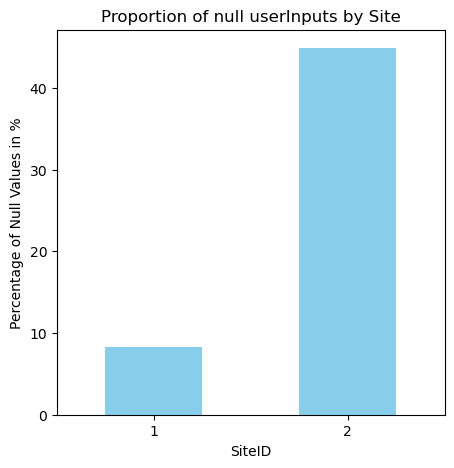

Number of rows for Site 1: 32216
Number of rows for Site 2: 31408


In [366]:
null_proportion = charging.groupby('siteID')['userInputs_kWhRequested'].apply(lambda x: x.isnull().mean() * 100)

# show visually how many percent of each site gave null values
null_proportion.plot(kind='bar', color='skyblue', figsize=(5, 5))
plt.title('Proportion of null userInputs by Site')
plt.ylabel('Percentage of Null Values in %')
plt.xlabel('SiteID')
plt.xticks(rotation=0)
plt.show()


print(f"Number of rows for Site 1: {charging[charging['siteID'] == 1].shape[0]}")
print(f"Number of rows for Site 2: {charging[charging['siteID'] == 2].shape[0]}")


In [367]:
user_input_columns = [
    'userInputs_WhPerMile', 
    'userInputs_kWhRequested', 
    'userInputs_milesRequested', 
    'userInputs_minutesAvailable', 
    'userInputs_modifiedAt', 
    'userInputs_paymentRequired', 
    'userInputs_requestedDeparture'
]


for column in user_input_columns:
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(charging[column]):
        mean_value = charging[column].mean(skipna=True)  # calculate mean of non-null values
        charging[column].fillna(mean_value, inplace=True)  # replace nulls with mean


C:\Users\Willi\AppData\Local\Temp\ipykernel_6400\2302363507.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  charging[column].fillna(mean_value, inplace=True)  # replace nulls with mean


In [368]:
print(charging.isnull().sum())

id                                   0
connectionTime                       0
disconnectTime                       0
doneChargingTime                     0
kWhDelivered                         0
sessionID                            0
siteID                               0
spaceID                              0
stationID                            0
userID                               0
userInputs_WhPerMile                 0
userInputs_kWhRequested              0
userInputs_milesRequested            0
userInputs_minutesAvailable          0
userInputs_modifiedAt            16754
userInputs_paymentRequired       16754
userInputs_requestedDeparture    16754
done_after_disconnect                0
connectionDay                        0
disconnectionDay                     0
date_matches                         0
dtype: int64


Now all numeric varaibles are replaced with the mean of their respective column. The last null rows are the modifiedAt, requestedDeparture and paymentrequired(boolean).

As we see below, there isn't a single row in the column "paymentRequired" which has the value "False". This could maybe mean that the rows with paymentRequired are registered users while the one in which it is null are unregistered users

In [371]:
true_count = (charging['userInputs_paymentRequired'] == True).sum()

print(f"Number of True values in 'userInputs_paymentRequired': {true_count}")

false_count = (charging['userInputs_paymentRequired'] == False).sum()

print(f"Number of False values in 'userInputs_paymentRequired': {false_count}")



Number of True values in 'userInputs_paymentRequired': 46870
Number of False values in 'userInputs_paymentRequired': 0


<h1> TO-DO for later: Null values meaning </h1>

In [373]:
charging.to_csv('charging_cleaned.csv', index=False)

# See if one spaceID corresponds to a single siteID -> TODO: Yes, maybe remove one of them?

In [375]:
# Group by spaceID and count the number of unique stationIDs for each spaceID
space_to_station = charging.groupby('spaceID')['stationID'].nunique()

# Filter for spaceIDs that map to more than one stationID
multiple_mappings = space_to_station[space_to_station > 1]

print(f"SpaceIDs with more than one unique stationID:\n{multiple_mappings}")

# Check specific example: Does 'AG-3F30' always have '1-1-179-810'?
specific_spaceID = 'AG-3F30'
specific_mapping = charging[charging['spaceID'] == specific_spaceID]['stationID'].unique()

print(f"stationIDs corresponding to spaceID '{specific_spaceID}': {specific_mapping}")


SpaceIDs with more than one unique stationID:
Series([], Name: stationID, dtype: int64)
stationIDs corresponding to spaceID 'AG-3F30': ['1-1-179-810']


# TODO: convert the userinputs dates to the same format as the connection and disconnect times

<h1> Clean weather data </h1>

In [378]:
# import weather data
weather = pd.read_csv("../weather_burbank_airport.csv", encoding = "ISO-8859-1")
weather.head()


,city,timestamp,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,felt_temperature
0,Burbank,2018-01-01 08:53:00,9.0,33.0,Fair,991.75,9.0,0.0,8.0
1,Burbank,2018-01-01 09:53:00,9.0,33.0,Fair,992.08,0.0,0.0,9.0
2,Burbank,2018-01-01 10:53:00,9.0,21.0,Haze,992.08,0.0,0.0,9.0
3,Burbank,2018-01-01 11:53:00,9.0,29.0,Partly Cloudy,992.08,0.0,0.0,9.0
4,Burbank,2018-01-01 12:53:00,8.0,33.0,Fair,992.08,0.0,0.0,8.0


In [379]:
print(weather['city'].unique())

['Burbank']


In [380]:
#Remove first Column because every cell has the same value (Burbank).
weather = weather.drop(columns=['city'])
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29244 entries, 0 to 29243
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                29244 non-null  object 
 1   temperature              29219 non-null  float64
 2   cloud_cover              29224 non-null  float64
 3   cloud_cover_description  29224 non-null  object 
 4   pressure                 29236 non-null  float64
 5   windspeed                29158 non-null  float64
 6   precipitation            29244 non-null  float64
 7   felt_temperature         29218 non-null  float64
dtypes: float64(6), object(2)
memory usage: 1.8+ MB


In [381]:
#convert to correct datetime
weather['timestamp'] = pd.to_datetime(weather['timestamp'])
print(weather.dtypes)

timestamp                  datetime64[ns]
temperature                       float64
cloud_cover                       float64
cloud_cover_description            object
pressure                          float64
windspeed                         float64
precipitation                     float64
felt_temperature                  float64
dtype: object


In [382]:
# print for each row how many null values there are
print(weather.isna().sum())

timestamp                   0
temperature                25
cloud_cover                20
cloud_cover_description    20
pressure                    8
windspeed                  86
precipitation               0
felt_temperature           26
dtype: int64


In [383]:
# Replace null values in with interpolation where value is mean between 2 non-null values, as the data doesnt change abrutply but gradually
weather['temperature'] = weather['temperature'].interpolate(method='linear', limit_direction='forward', axis=0)
weather['pressure'] = weather['pressure'].interpolate(method='linear', limit_direction='forward', axis=0)
weather['felt_temperature'] = weather['felt_temperature'].interpolate(method='linear', limit_direction='forward', axis=0)

#Replace null values of windspeed with median as the data is not normal distributed (see code right below)
weather['windspeed'] = weather['windspeed'].fillna(weather['cloud_cover'].median(skipna=True)) 

#Replace missing values of cloud_cover with the last value, as cloud_cover is categorial and we can't compute any mean here
weather['cloud_cover'] = weather['cloud_cover'].fillna(method='ffill')  # Forward fill

C:\Users\Willi\AppData\Local\Temp\ipykernel_6400\440695532.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather['cloud_cover'] = weather['cloud_cover'].fillna(method='ffill')  # Forward fill


<h1>Interpolation check if longer periods are null -> check period length </h1>

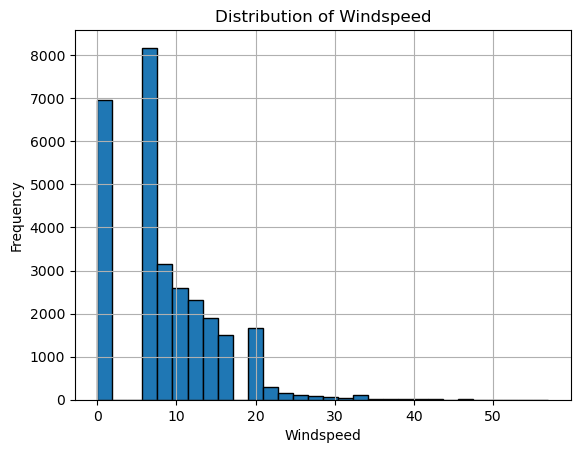

In [385]:
# Show distribution of windspeed in histogram
weather['windspeed'].hist(bins=30, edgecolor='black')

plt.title('Distribution of Windspeed')
plt.xlabel('Windspeed')
plt.ylabel('Frequency')
plt.show()


<h5/>Fill the null values for cloud_cover description with forward propagating because each row always has a difference of one hour and the dataset is already sorted by date -> description of a null value and its predecessor should be very similar because in a span of one hour, the cloud_cover description shouldn't change that much

<h5> Forward propagating is a good solution here because the data is categorial </h5%

In [388]:
weather['cloud_cover_description'] = weather['cloud_cover_description'].ffill()

In [389]:
print(charging.isnull().sum())

id                                   0
connectionTime                       0
disconnectTime                       0
doneChargingTime                     0
kWhDelivered                         0
sessionID                            0
siteID                               0
spaceID                              0
stationID                            0
userID                               0
userInputs_WhPerMile                 0
userInputs_kWhRequested              0
userInputs_milesRequested            0
userInputs_minutesAvailable          0
userInputs_modifiedAt            16754
userInputs_paymentRequired       16754
userInputs_requestedDeparture    16754
done_after_disconnect                0
connectionDay                        0
disconnectionDay                     0
date_matches                         0
dtype: int64


In [390]:
weather.to_csv('weather_cleaned.csv', index=False)

In [391]:
print(weather.isna().sum())

timestamp                  0
temperature                0
cloud_cover                0
cloud_cover_description    0
pressure                   0
windspeed                  0
precipitation              0
felt_temperature           0
dtype: int64
